# Mixture of Gaussians experiment using L2HMC

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples

## Network architecture

We define the network architecture for our L2HMC network. We first embed the first two variables ($\{x, \partial_x U\}$ or $\{v, x_m\}$) as well as the time, formatted as $\tau(t) = \left(\cos(\frac{2\pi t}{M}), \sin(\frac{2\pi t}{M})\right)$. They are forwarded through an MLP and then produce $S, T$ and $Q$.

In [3]:
def network(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, 10, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, 10, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, 10, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(10, 10, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(10, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(10, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(10, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net

## Distribution

We define our energy function. It is a Gaussian distribution with zero mean. The covariance is a $\pi/4$ rotation of the eigenvalues $[100, 10^{-1}]$. We set up our dynamics which take as input our energy function, the number of time step of our operator, the (learnable) step-size and our architecture.

In [4]:
x_dim = 2
means = [np.array([2., 0.0]).astype(np.float32), 
         np.array([-2.0, 0.0]).astype(np.float32)]
covs = [np.array([[0.1, 0.0],[0.0, 0.1]]), np.array([[0.1, 0.0],[0.0, 0.1]])]
distribution = GMM(means, covs, [0.5, 0.5])
# Get some samples from the true distribution for debugging
init_samples = distribution.get_samples(200)
np.save('init_samples', init_samples)

In [5]:
dynamics = Dynamics(x_dim, distribution.get_energy_function(), 
                    T=5, eps=0.1, net_factory=network, use_temperature=True)

In [6]:
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))

Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

loss = 0.

v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 1

loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale

In [7]:
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 200, 0.98, 
                                           staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

In [12]:
n_steps = 10000
n_samples = 200
losses = []
samples = np.zeros((n_samples, x_dim))
#samples = np.random.randn(n_samples, x_dim)
#samples = distribution.get_samples(n_samples)

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
temp = 5

In [14]:
import time
time1 = time.time()

for t in range(n_steps // 2):
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], {x: samples, dynamics.temperature: temp})
    losses.append(loss_)

    if t % 100 == 0:
        print(
            'Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (
            t, n_steps, loss_, np.mean(px_), lr_))
        temp *= 0.98
        
time2 = time.time()
dt1 = time2 - time1
print(f'Time to train sampler for {n_steps//2} was {dt1} seconds')

Step: 0 / 10000, Loss: 2.33e+01, Acceptance sample: 0.99, LR: 0.00100
Step: 100 / 10000, Loss: 2.16e+01, Acceptance sample: 0.97, LR: 0.00100
Step: 200 / 10000, Loss: 3.48e+01, Acceptance sample: 0.94, LR: 0.00098
Step: 300 / 10000, Loss: 1.65e+01, Acceptance sample: 0.93, LR: 0.00098
Step: 400 / 10000, Loss: 1.43e+01, Acceptance sample: 0.92, LR: 0.00096
Step: 500 / 10000, Loss: 1.29e+01, Acceptance sample: 0.87, LR: 0.00096
Step: 600 / 10000, Loss: 1.40e+01, Acceptance sample: 0.91, LR: 0.00094
Step: 700 / 10000, Loss: 1.24e+01, Acceptance sample: 0.88, LR: 0.00094
Step: 800 / 10000, Loss: 1.12e+01, Acceptance sample: 0.87, LR: 0.00092
Step: 900 / 10000, Loss: 1.74e+01, Acceptance sample: 0.85, LR: 0.00092
Step: 1000 / 10000, Loss: 1.20e+01, Acceptance sample: 0.86, LR: 0.00090
Step: 1100 / 10000, Loss: 1.11e+01, Acceptance sample: 0.86, LR: 0.00090
Step: 1200 / 10000, Loss: 7.04e+00, Acceptance sample: 0.82, LR: 0.00089
Step: 1300 / 10000, Loss: 5.57e+00, Acceptance sample: 0.82, LR

In [22]:
time3 = time.time()
for t in range(n_steps // 2, n_steps):
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], {x: samples, dynamics.temperature: temp})
    losses.append(loss_)

    if t % 100 == 0:
        print(
            'Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (
            t, n_steps, loss_, np.mean(px_), lr_))
        temp *= 0.98
 
time4 = time.time()
dt2 = time4 - time3
print(f'Time to train sampler for {n_steps - n_steps//2} was {dt2} seconds')
#print('Time to train sampler was {} seconds'.format(time2 - time1))

Step: 5000 / 10000, Loss: -3.10e+00, Acceptance sample: 0.78, LR: 0.00060
Step: 5100 / 10000, Loss: 4.74e+00, Acceptance sample: 0.72, LR: 0.00060
Step: 5200 / 10000, Loss: 2.76e+00, Acceptance sample: 0.71, LR: 0.00059
Step: 5300 / 10000, Loss: -2.27e+00, Acceptance sample: 0.72, LR: 0.00059
Step: 5400 / 10000, Loss: -2.47e+00, Acceptance sample: 0.70, LR: 0.00058
Step: 5500 / 10000, Loss: 8.94e-01, Acceptance sample: 0.75, LR: 0.00058
Step: 5600 / 10000, Loss: -6.11e-01, Acceptance sample: 0.78, LR: 0.00057
Step: 5700 / 10000, Loss: -1.71e+00, Acceptance sample: 0.80, LR: 0.00057
Step: 5800 / 10000, Loss: -1.77e+00, Acceptance sample: 0.76, LR: 0.00056
Step: 5900 / 10000, Loss: 2.90e-01, Acceptance sample: 0.80, LR: 0.00056
Step: 6000 / 10000, Loss: -1.91e+00, Acceptance sample: 0.82, LR: 0.00055
Step: 6100 / 10000, Loss: -5.66e-01, Acceptance sample: 0.80, LR: 0.00055
Step: 6200 / 10000, Loss: -2.41e+00, Acceptance sample: 0.81, LR: 0.00053
Step: 6300 / 10000, Loss: 2.10e+01, Accept

After training, we generate $200$ chains for $2000$ steps for evaluation purposes.

In [15]:
final_samples1 = []

for t in range(2000):
    final_samples1.append(np.copy(samples))

    feed_dict = {
        x: samples, dynamics.temperature: 5.0,
    }

    samples = sess.run(output[0], feed_dict)

np.save('mogsamples1_with_temp', np.array(final_samples1))
L2HMC_samples1 = np.array(final_samples1)

In [23]:
final_samples2 = []

for t in range(2000):
    final_samples2.append(np.copy(samples))

    feed_dict = {
        x: samples, dynamics.temperature: 5.0,
    }

    samples = sess.run(output[0], feed_dict)

np.save('mogsamples2_with_temp', np.array(final_samples2))
L2HMC_samples2 = np.array(final_samples2)

We compute the HMC chains with **auto-correlation spectrums** as well.

In [25]:
HMC_samples_1 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_2 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_3 = get_hmc_samples(2, 0.25, distribution.get_energy_function(), sess, steps=2000, samples=samples)

In [26]:
scale = np.sqrt(np.trace(covs))
L2HMC = acl_spectrum(L2HMC_samples1, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

We can plot auto-correlation.

Text(0,0.5,'Auto-correlation')

Text(0.5,0,'Gradient Computations')

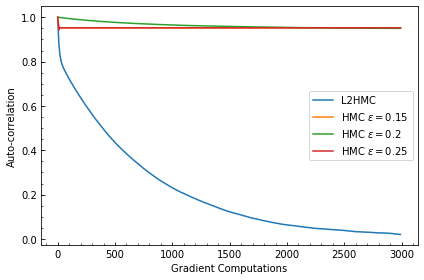

In [30]:
xaxis = 10 * np.arange(300)
fig, ax = plt.subplots()
ax.plot(xaxis, L2HMC[:300]/max(L2HMC[:300]), label='L2HMC')
plt.plot(xaxis, HMC1[:300]/max(HMC1[:300]), label='HMC $\epsilon=0.15$')
ax.plot(xaxis, HMC2[:300]/max(HMC2[:300]), label='HMC $\epsilon=0.2$')
ax.plot(xaxis, HMC3[:300]/max(HMC3[:300]), label='HMC $\epsilon=0.25$')
ax.set_ylabel('Auto-correlation')
ax.set_xlabel('Gradient Computations')
ax.legend()
fig.tight_layout()
fig.savefig('./auto_correlation_vs_grad_comps_MoG.png', 
            dpi=400, bbox_inches='tight')
plt.show()

We now compute the **Effective Sample Size** (ESS).

In [31]:
print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

ESS L2HMC: 1.23e-04 -- ESS HMC: 6.24e-06 -- Ratio: 19


We can visualize a single chain of both HMC and L2HMC for $500$ time steps.


Text(0.5,1,'Single chain of HMC $(\\epsilon = 0.15)$ for 1000 time steps')

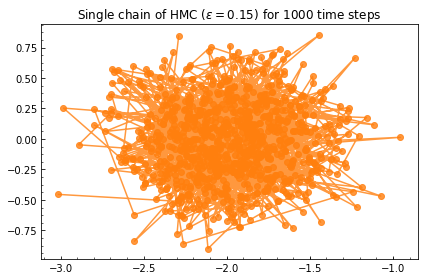

In [60]:
fig, ax = plt.subplots()
ax.plot(HMC_samples_1[:1000, 0, 0], HMC_samples_1[:1000, 0, 1], 
         color='C1', marker='o', alpha=0.8, ls='-')
ax.set_title("Single chain of HMC $(\epsilon = 0.15)$ for 1000 time steps")
fig.tight_layout()
fig.savefig('./MoG_HMC_chain_e015_1000t.png', dpi=400, bbox_inches='tight')
plt.show()

## Intermediate L2HMC MCMC chains (after 5000 training steps)

Text(0.5,1,'1000 time steps of L2HMC MCMC chain, 5000 training steps')

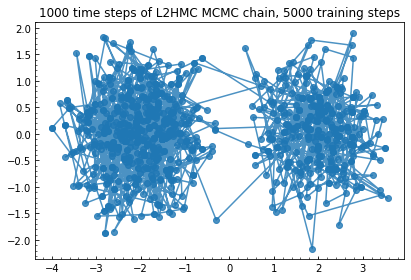

In [58]:
#for i in range(20):
    #print(f'i: {i}')
fig, ax = plt.subplots()
ax.plot(L2HMC_samples1[:1000, 5, 0], L2HMC_samples1[:1000, 5, 1], 
         color='C0', marker='o', alpha=0.8, ls='-')
ax.set_title("1000 time steps of L2HMC MCMC chain, 5000 training steps")
fig.tight_layout()
fig.savefig('./MoG_MCMC_chain_1000t_5000train.png', dpi=400, bbox_inches='tight')
plt.show()

## Final L2HMC MCMC chains (after 10,000 training steps)

Text(0.5,1,'1000 time steps of L2HMC MCMC chain, 10000 training steps')

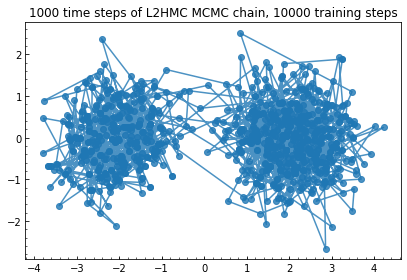

In [59]:
#for i in range(20):
    #print(f'i: {i}')
fig, ax = plt.subplots()
ax.plot(L2HMC_samples2[:1000, 5, 0], L2HMC_samples2[:1000, 5, 1], 
         color='C0', marker='o', alpha=0.8, ls='-')
ax.set_title("1000 time steps of L2HMC MCMC chain, 10000 training steps")
fig.tight_layout()
fig.savefig('./MoG_MCMC_chain_1000t_10000train.png', dpi=400, bbox_inches='tight')
plt.show()